# 1. About the project
Zomato API Analysis is one of the most useful analysis for foodies who want to taste the best cuisines of every part of the world which lies in their budget. 
This analysis is also for those who want to find the value for money restaurants in various parts of the country for the cuisines. 
Additionally, this analysis caters the needs of people who are striving to get the best cuisine of the country and which locality of that country serves that cuisines with maximum number of restaurants.

Main goal of this project is to get prediction (Yes or No) for the question: 
Do I have to book a table in the restaurant with these features?

# 2. Dataset
All Data has been collected from the Zomato API.
The collected data has been stored in the Comma Separated Value file Zomato.csv

You can get access to this from Kaggle:
https://www.kaggle.com/akashram/zomato-restaurants-autoupdated-dataset/version/1?select=zomato.csv

Each restaurant in the dataset is uniquely identified by its Restaurant Id
Every Restaurant contains the following variables:

• Restaurant Id: Unique id of every restaurant across various cities of the world
• Restaurant Name: Name of the restaurant
• Country Code: Country in which restaurant is located
• City: City in which restaurant is located
• Address: Address of the restaurant
• Locality: Location in the city
• Locality Verbose: Detailed description of the locality
• Longitude: Longitude coordinate of the restaurant's location
• Latitude: Latitude coordinate of the restaurant's location
• Cuisines: Cuisines offered by the restaurant
• Average Cost for two: Cost for two people in different currencies 👫
• Currency: Currency of the country
• Has Table booking: yes/no
• Has Online delivery: yes/ no
• Is delivering: yes/ no
• Switch to order menu: yes/no
• Price range: range of price of food
• Aggregate Rating: Average rating out of 5
• Rating color: depending upon the average rating color
• Rating text: text on the basis of rating of rating
• Votes: Number of ratings casted by people

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score 
from sklearn.metrics import auc
import xgboost as xgb

from sklearn.feature_extraction import DictVectorizer

from sklearn import preprocessing

import pickle

warnings.filterwarnings("ignore")
datafile = 'zomato.csv'
df = pd.read_csv(datafile)
df.columns = df.columns.str.lower().str.replace(' ', '_')
strings = list(df.dtypes[df.dtypes == 'object'].index)
for col in strings:
    df[col] = df[col].str.lower()
columns = ['restaurant_name','city','currency','rating_text','locality','cuisines']
for c in columns:
    df[c] = df[c].str.replace(' ', '_')
for c in columns:
    df[c] = df[c].str.replace(',_', ',')
del df['locality_verbose']
del df['address']
del df['locality']
del df['restaurant_id']
del df['rating_color']
del df['rating_text']

In [2]:
print('Quoantity of records in dataset:', len(df))

Quoantity of records in dataset: 7527


# 3. EDA

In [3]:
#Check if all the columns have correct data types (Yes, they have)
df_head = df.head(5).T
dtypes = list(df.dtypes.values)
df_head.insert(loc=0,column='dtype',value=dtypes)
df_head

,dtype,0,1,2,3,4
restaurant_name,object,mama_lou's_italian_kitchen,mama_lou's_italian_kitchen,blackbird,banapple,bad_bird
country_code,int64,162,162,162,162,162
city,object,las_piñas_city,las_piñas_city,makati_city,makati_city,makati_city
longitude,float64,121.01,121.01,121.025,121.023,121.028
latitude,float64,14.4476,14.4476,14.556,14.5562,14.5659
cuisines,object,italian,italian,"european,asian","filipino,american,italian,bakery",american
average_cost_for_two,int64,1100,1100,3100,800,700
currency,object,botswana_pula(p),botswana_pula(p),botswana_pula(p),botswana_pula(p),botswana_pula(p)
has_table_booking,int64,1,1,0,0,0
has_online_delivery,int64,0,0,0,0,0


In [4]:
#Check for missing data
df.isnull().sum()

restaurant_name          0
country_code             0
city                     0
longitude                0
latitude                 0
cuisines                15
average_cost_for_two     0
currency                 0
has_table_booking        0
has_online_delivery      0
is_delivering_now        0
switch_to_order_menu     0
price_range              0
aggregate_rating         0
votes                    0
dtype: int64

In [5]:
#Fix missing data with NA value
df.cuisines = df.cuisines.fillna('NA')

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
cuisines = df.cuisines
cv = CountVectorizer()
cv.fit(cuisines)
X = cv.transform(cuisines)
#print(cv.get_feature_names())

In [58]:
#df2 = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())

In [8]:
#Numerical and Categorical features
num_cols = list(df.columns[df.dtypes != 'object'])
cat_cols = list(df.columns[df.dtypes == 'object'])

display(num_cols)
display(cat_cols)

['country_code',
 'longitude',
 'latitude',
 'average_cost_for_two',
 'has_table_booking',
 'has_online_delivery',
 'is_delivering_now',
 'switch_to_order_menu',
 'price_range',
 'aggregate_rating',
 'votes']

['restaurant_name', 'city', 'cuisines', 'currency']

In [9]:
#Check if any of the numerical columns have significantly high values 
df[num_cols].describe().T.applymap(lambda x: f"{x:0.3f}")

,count,mean,std,min,25%,50%,75%,max
country_code,7527.000,93.065,99.031,1.000,1.000,30.000,214.000,216.000
longitude,7527.000,33.764,77.395,-122.700,-4.258,73.785,79.834,175.311
latitude,7527.000,19.333,23.256,-41.330,12.923,25.247,31.637,55.977
average_cost_for_two,7527.000,7152.113,290606.828,0.000,60.000,290.000,600.000,25000017.000
has_table_booking,7527.000,0.062,0.241,0.000,0.000,0.000,0.000,1.000
has_online_delivery,7527.000,0.352,0.478,0.000,0.000,0.000,1.000,1.000
is_delivering_now,7527.000,0.174,0.379,0.000,0.000,0.000,0.000,1.000
switch_to_order_menu,7527.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
price_range,7527.000,2.625,0.960,1.000,2.000,3.000,3.000,4.000
aggregate_rating,7527.000,4.118,0.680,0.000,4.000,4.200,4.500,4.900


<AxesSubplot:xlabel='average_cost_for_two', ylabel='Density'>

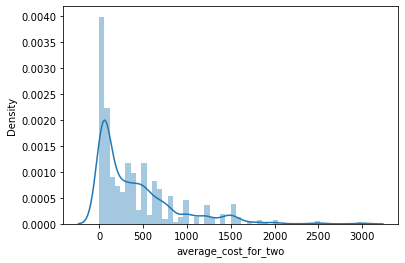

In [10]:
# As we can see on plot, average_cost_for_two column includes very big values and we're deleting them
df = df.drop(df[df.average_cost_for_two > 3000].index)
sns.distplot(df.average_cost_for_two)

In [11]:
#Also We have to drop switch_to_order_menu column because it has 0 value all the time
del df['switch_to_order_menu']

In [12]:
#For categorical features, check cardinality
df[cat_cols].describe().T

,count,unique,top,freq
restaurant_name,7414,5821,domino's_pizza,204
city,7414,122,nagpur,99
cuisines,7414,2796,"pizza,fast_food",238
currency,7414,11,indian_rupees(rs.),3505


In [13]:
#Number of distinct values for each categorical feature
df[cat_cols].nunique()

restaurant_name    5821
city                122
cuisines           2796
currency             11
dtype: int64

In [14]:
#Distinct values and their count for each categorical feature
for c in cat_cols:
    print(c)
    display(df[c].value_counts())
    print()

restaurant_name


domino's_pizza            204
kfc                        51
pizza_hut                  40
mcdonald's                 36
barbeque_nation            32
                         ... 
goro_+_gun                  1
corner_house_ice_cream      1
versailles                  1
señor_pollo                 1
modern_cafe                 1
Name: restaurant_name, Length: 5821, dtype: int64


city


nagpur           99
abu_dhabi        95
birmingham       95
surat            95
cape_town        94
                 ..
roodepoort        1
zirakpur          1
pasay_city        1
marikina_city     1
gandhinagar       1
Name: city, Length: 122, dtype: int64


cuisines


pizza,fast_food                                              238
italian                                                      173
north_indian                                                 165
cafe                                                         136
american                                                     126
                                                            ... 
north_indian,continental,mediterranean,asian,bbq,desserts      1
seafood,american,mediterranean,japanese                        1
continental,north_indian,italian,south_indian,finger_food      1
south_indian,singaporean,middle_eastern,indian                 1
italian,steak,american                                         1
Name: cuisines, Length: 2796, dtype: int64


currency


indian_rupees(rs.)       3505
dollar($)                1836
pounds(£)                 437
rand(r)                   381
emirati_diram(aed)        334
brazilian_real(r$)        261
newzealand($)             253
turkish_lira(tl)          165
qatari_rial(qr)            94
botswana_pula(p)           86
sri_lankan_rupee(lkr)      62
Name: currency, dtype: int64

4.2

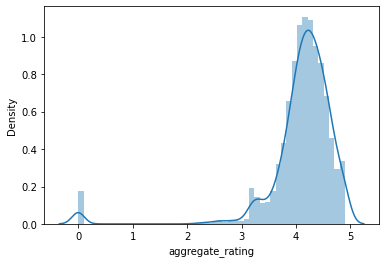

In [15]:
#Let's analyze our target variable 'aggregate_rating'
sns.distplot(df.aggregate_rating)
df.aggregate_rating.median()

In [16]:
#Median value of the target variable is 4.2
#Let's set that we book the table in the restaurant if it's above average (>=4.2) according to rating
#Replace 'aggregate_rating' with new 'book_decision' value. 
#If it's true the restaurant is Ok for booking

book_decision = (df.aggregate_rating >= 4.2)
df['book_decision'] = book_decision.astype(int)
del df['aggregate_rating']
df.T

,0,1,3,4,5,6,7,8,9,10,...,7517,7518,7519,7520,7521,7522,7523,7524,7525,7526
restaurant_name,mama_lou's_italian_kitchen,mama_lou's_italian_kitchen,banapple,bad_bird,manam,soban_k-town_grill,bluesmith_coffee_&_kitchen,motorino_pizzeria_napoletana,shi_lin,nikkei,...,happy_moon's,happy_moon's,the_hunger_cafe_&_brasserie,ercan_steakhouse,sarıhan,eataly,tarihi_çınaraltı_aile_çay_bahçesi,boon_cafe_&_restaurant,kanaat_lokantası,katibim
country_code,162,162,162,162,162,162,162,162,162,162,...,208,208,208,208,208,208,208,208,208,208
city,las_piñas_city,las_piñas_city,makati_city,makati_city,makati_city,makati_city,makati_city,makati_city,makati_city,makati_city,...,i̇stanbul,i̇stanbul,i̇stanbul,i̇stanbul,i̇stanbul,i̇stanbul,i̇stanbul,i̇stanbul,i̇stanbul,i̇stanbul
longitude,121.01,121.01,121.023,121.028,121.02,121.021,121.021,121.022,121.022,121.018,...,29.0998,29.0998,29.0998,28.8028,28.8049,29.0173,29.0526,29.0526,29.0166,29.0108
latitude,14.4476,14.4476,14.5562,14.5659,14.5524,14.5522,14.552,14.5519,14.5522,14.5558,...,40.998,40.998,40.9981,41.0883,41.085,41.0653,41.0503,41.0507,41.0257,41.0255
cuisines,italian,italian,"filipino,american,italian,bakery",american,filipino,"korean,grill","american,filipino,coffee","pizza,italian",taiwanese,"japanese,latin_american",...,world_cuisine,world_cuisine,world_cuisine,steak,"giblets,izgara,home-made","italian,pizza,fresh_fish","fast_food,izgara,seafood,tea,coffee",restaurant_cafe,"home-made,izgara","restaurant_cafe,kebab,turkish_pizza"
average_cost_for_two,1100,1100,800,700,700,1300,700,1000,1000,1600,...,200,200,190,200,100,300,45,140,95,150
currency,botswana_pula(p),botswana_pula(p),botswana_pula(p),botswana_pula(p),botswana_pula(p),botswana_pula(p),botswana_pula(p),botswana_pula(p),botswana_pula(p),botswana_pula(p),...,turkish_lira(tl),turkish_lira(tl),turkish_lira(tl),turkish_lira(tl),turkish_lira(tl),turkish_lira(tl),turkish_lira(tl),turkish_lira(tl),turkish_lira(tl),turkish_lira(tl)
has_table_booking,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
has_online_delivery,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Splitting data as Train (60%), Val (20%), Test (20%)
df_full_train, df_test = train_test_split(df,test_size=0.2,shuffle=True,random_state=1)
df_train, df_val = train_test_split(df_full_train,test_size=0.25,shuffle=True,random_state=1)
print(f'train : {round(df_train.shape[0]/df.shape[0],2)}, val: {round(df_val.shape[0]/df.shape[0],2)}, test: {round(df_test.shape[0]/df.shape[0],2)}')

train : 0.6, val: 0.2, test: 0.2


In [18]:
display(df_full_train['book_decision'].value_counts(normalize=True))
display(df_train['book_decision'].value_counts(normalize=True))
display(df_val['book_decision'].value_counts(normalize=True))
display(df_test['book_decision'].value_counts(normalize=True))

1    0.570561
0    0.429439
Name: book_decision, dtype: float64

1    0.564074
0    0.435926
Name: book_decision, dtype: float64

1    0.59002
0    0.40998
Name: book_decision, dtype: float64

1    0.554282
0    0.445718
Name: book_decision, dtype: float64

In [19]:
y_train = df_train['book_decision'].values
y_val = df_val['book_decision'].values
y_test = df_test['book_decision'].values

del df_train['book_decision']
del df_val['book_decision']
del df_test['book_decision']

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

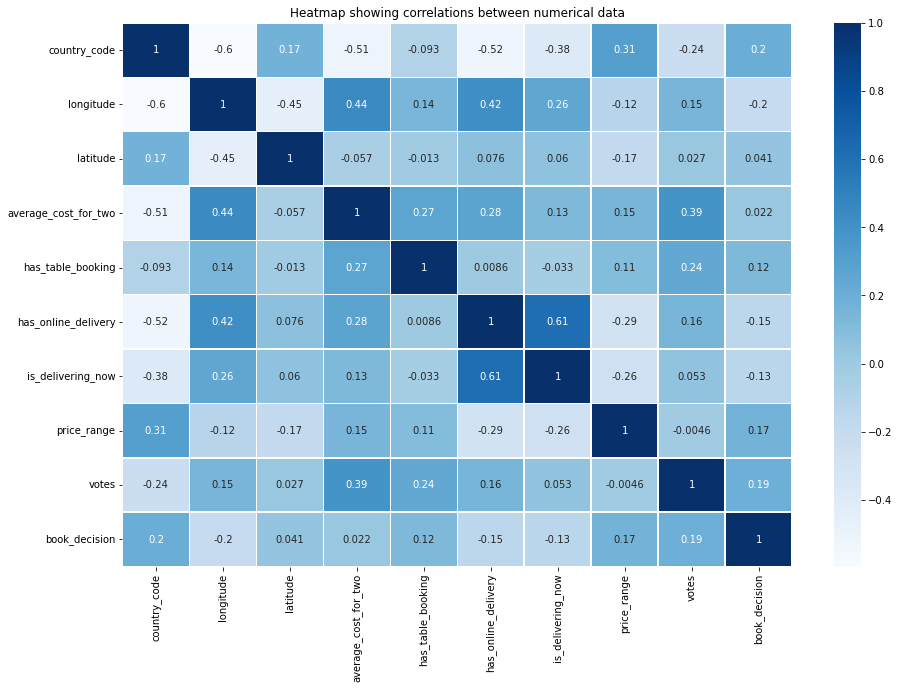

In [20]:
#EDA:Heatmap showing correlations between numerical data
num_cols = list(df_full_train.columns[df.dtypes != 'object'])
data_numeric = df_full_train.copy()
data_numeric = data_numeric[num_cols]
plt.figure(figsize=(15,10))  
sns.heatmap(data_numeric.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [21]:
#EDA: The same correlations between numerical data but in text format:
data_numeric.corr().unstack().sort_values(ascending = False).head(25)

book_decision         book_decision           1.000000
votes                 votes                   1.000000
longitude             longitude               1.000000
latitude              latitude                1.000000
average_cost_for_two  average_cost_for_two    1.000000
has_table_booking     has_table_booking       1.000000
has_online_delivery   has_online_delivery     1.000000
is_delivering_now     is_delivering_now       1.000000
price_range           price_range             1.000000
country_code          country_code            1.000000
has_online_delivery   is_delivering_now       0.614542
is_delivering_now     has_online_delivery     0.614542
average_cost_for_two  longitude               0.444664
longitude             average_cost_for_two    0.444664
                      has_online_delivery     0.416883
has_online_delivery   longitude               0.416883
votes                 average_cost_for_two    0.387877
average_cost_for_two  votes                   0.387877
country_co

In [22]:
# Mutual information with categorical features
def mutual_info_subscribed_score(series):
    return mutual_info_score(series,df_full_train['book_decision'])

mi = df_full_train[cat_cols].apply(mutual_info_subscribed_score)
mi.sort_values(ascending=False)

restaurant_name    0.633050
cuisines           0.350783
city               0.151760
currency           0.055272
dtype: float64

In [23]:
# Co-relation of numerical features with target variable
df_full_train[num_cols].corrwith(df_full_train['book_decision']).sort_values()

longitude              -0.195013
has_online_delivery    -0.145357
is_delivering_now      -0.129903
average_cost_for_two    0.022089
latitude                0.041014
has_table_booking       0.121532
price_range             0.167086
votes                   0.190798
country_code            0.202518
book_decision           1.000000
dtype: float64

# 4. Baseline model - LogisticRegression
Let's check baseline model using LogisticRegression with default parameters and evaluating using roc_auc_score

In [24]:
dv = DictVectorizer(sparse=False)
model = LogisticRegression(solver='liblinear',random_state=42, max_iter=1000)

In [25]:
dict_train = df_train.to_dict(orient='records')
X_train = dv.fit_transform(dict_train)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [26]:
dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [27]:
dict_val = df_val.to_dict(orient='records')
X_val = dv.transform(dict_val)

y_pred_lr = model.predict(X_val)

lr_score = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy Score of Logistic Regression: {lr_score}")

cm = confusion_matrix(y_test, y_pred_lr)
cm



Accuracy Score of Logistic Regression: 0.49763991908294


array([[249, 412],
       [333, 489]])

In [28]:
y_test_pred = model.predict_proba(X_test)[:,1]

roc_lr = roc_auc_score(y_test, y_test_pred)

print(f'Roc_auc_score of Logistic Regression: {roc_lr}')

Roc_auc_score of Logistic Regression: 0.8300481096620546


In [29]:
clf_report = classification_report(y_test, y_pred_lr)
print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0       0.43      0.38      0.40       661
           1       0.54      0.59      0.57       822

    accuracy                           0.50      1483
   macro avg       0.49      0.49      0.48      1483
weighted avg       0.49      0.50      0.49      1483



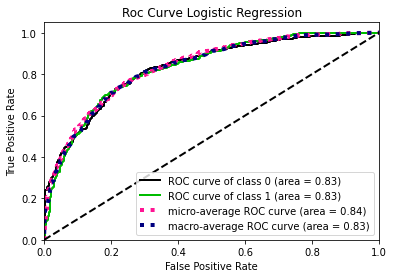

In [30]:
from sklearn import metrics
import scikitplot as skplt
y_pred_lr_prob = model.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_pred_lr_prob)
plt.title('Roc Curve Logistic Regression')
plt.show()

In [51]:
#Test for regression model
restaurant = dicts_test[99]
restaurant

{'restaurant_name': 'via_delhi',
 'country_code': 214,
 'city': 'abu_dhabi',
 'longitude': 54.374273233100006,
 'latitude': 24.4910933909,
 'cuisines': 'indian,north_indian,chinese',
 'average_cost_for_two': 100,
 'currency': 'emirati_diram(aed)',
 'has_table_booking': 0,
 'has_online_delivery': 1,
 'is_delivering_now': 1,
 'price_range': 3,
 'votes': 1148}

In [52]:
X_small = dv.transform([restaurant])
model.predict_proba(X_small)[0, 1]

0.7067742139274422

In [61]:
y_test[99]

1

# 5. Second model - Decision tree classifier


In [68]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print(dtc.get_params()) 

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [69]:
y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
print(f"Accuracy Score of Decision Tree (test dataset) is : {acc_dtc}")

Accuracy Score of Decision Tree (test dataset) is : 0.734322319622387


In [70]:
y_pred_dtc = dtc.predict(X_val)

acc_dtc = accuracy_score(y_val, y_pred_dtc)
print(f"Accuracy Score of Decision Tree (validation dataset) is : {acc_dtc}")

Accuracy Score of Decision Tree (validation dataset) is : 0.7363452461227242


In [73]:
# Parameter tunning of Decision Tree: selecting a max_depth

numbers = [1, 2, 3, 4, 5, 6, 10, 15, 20, 25, 30, 40, 50, 60, None]

for d in numbers:
    dtc = tree.DecisionTreeClassifier(max_depth=d, random_state=42)

    dtc.fit(X_train, y_train)

    y_pred_dtc = dtc.predict(X_test)

    auc = accuracy_score(y_test, y_pred_dtc)

    print(" %4s -> %.3f " % (d, auc))

    1 -> 0.646 
    2 -> 0.646 
    3 -> 0.715 
    4 -> 0.732 
    5 -> 0.722 
    6 -> 0.736 
   10 -> 0.744 
   15 -> 0.744 
   20 -> 0.736 
   25 -> 0.726 
   30 -> 0.741 
   40 -> 0.739 
   50 -> 0.736 
   60 -> 0.736 
 None -> 0.736 


In [ ]:
#Growth seem to stop around max_depth [10,15]

In [74]:
# Now lets test the scores changing the amount of leafs

scores = []

for depth in [10, 12, 15]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:

        dt = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state=42)

        dt.fit(X_train, y_train)

        y_pred_dtc = dt.predict(X_test)

        auc = accuracy_score(y_test, y_pred_dtc)

        scores.append((depth, s, auc))

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

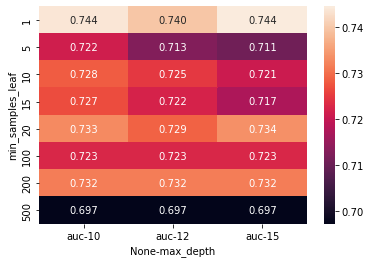

In [75]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf',
                                  columns=['max_depth'],
                                  values=['auc'])
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [ ]:
#The best score is at min_samples_leaf = 1 and max_depth of 10

In [76]:
dtc = tree.DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, random_state=42)
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
print(f"Accuracy Score of Decision Tree (test dataset) is : {acc_dtc}")

Accuracy Score of Decision Tree (test dataset) is : 0.7437626432906271


In [77]:
dtc = tree.DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, random_state=42)
dtc.fit(X_train, y_train)

y_val_dtc = dtc.predict(X_val)

acc_dtc = accuracy_score(y_val, y_val_dtc)
print(f"Accuracy Score of Decision Tree (Validation dataset) is : {acc_dtc}")

Accuracy Score of Decision Tree (Validation dataset) is : 0.7498314227916386


# 6. Third model - Random Forest

In [78]:
from sklearn.ensemble import RandomForestClassifier

Rf_model = RandomForestClassifier(n_estimators=20, random_state=42)
Rf_model.fit(X_train, y_train)
display(Rf_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [79]:
y_pred_rfm = Rf_model.predict(X_val)

acc_dtc = accuracy_score(y_val, y_pred_rfm)
print(
    f"Accuracy Score of Random Forest Classifier (Validation dataset) is : {acc_dtc}. \n"
)

print("Confussion Matrix\n")
print(confusion_matrix(y_test, y_pred_rfm))

roc_rf = roc_auc_score(y_val, y_pred_rfm)
print(f"Roc auc score : {roc_rf}")

Accuracy Score of Random Forest Classifier (Validation dataset) is : 0.7768037761294673. 

Confussion Matrix

[[265 396]
 [330 492]]
Roc auc score : 0.7676954887218044


In [80]:
print(f'Train Accuracy - : {Rf_model.score(X_train,y_train):.3f}')
print(f'Test Accuracy - : {Rf_model.score(X_test,y_test):.3f}')

Train Accuracy - : 0.998
Test Accuracy - : 0.758


# 7. Feature Importance for the Random Forest

In [81]:
importances = Rf_model.feature_importances_

#create a feature list
feature_list = list(df_train.columns)
feature_importance = sorted(zip(importances, feature_list), reverse=True)

df_imp = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance = list(df_imp['importance'])
feature = list(df_imp['feature'])

#see df
print(df_imp)

    importance               feature
0     0.053703       restaurant_name
1     0.003366                 votes
2     0.001892              cuisines
3     0.001795   has_online_delivery
4     0.001520  average_cost_for_two
5     0.001284             longitude
6     0.001184     has_table_booking
7     0.001089              currency
8     0.001049     is_delivering_now
9     0.000860          country_code
10    0.000859           price_range
11    0.000740              latitude
12    0.000221                  city


# 8 Parameter tunning of Random Forest

In [83]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "max_depth": [10, 13],
    "n_estimators": [10, 100],
    "min_samples_split": [2, 5]
}
rf = RandomForestClassifier()

rf_grid = GridSearchCV(estimator=rf,
                       param_grid=param_grid,
                       cv=10,
                       verbose=2,
                       n_jobs=-1)

rf_grid.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   1.0s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   0.5s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=10, min_samples_split=2, n_es

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 13], 'min_samples_split': [2, 5],
                         'n_estimators': [10, 100]},
             verbose=2)

In [84]:
rf_grid.best_params_

{'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 100}

In [85]:
print(f'Train Accuracy - : {rf_grid.score(X_train,y_train):.3f}')
print(f'Test Accuracy - : {rf_grid.score(X_test,y_test):.3f}')
print(f'Val Accuracy - : {rf_grid.score(X_val,y_val):.3f}')

Train Accuracy - : 0.806
Test Accuracy - : 0.742
Val Accuracy - : 0.736


In [86]:
y_pred_rfm_tuned = rf_grid.predict(X_test)

# 9 XGBoost using Scikit-Learn

In [89]:
xgb_params = {
            'learning_rate': 0.1,  # eta
            'max_depth':5,
            'n_estimators':5000, # max_amount
            'subsample':0.5, 
            'colsample_bytree':0.5, # half of the features will be used randomly
            'eval_metric':'auc', # area under auc curve as a metric
            'verbosity':2,
             "random_state" : 42

}
import xgboost
eval_set = [(X_test, y_test),(X_val, y_val)]

model_xgboost = xgboost.XGBClassifier(**xgb_params)

model_xgboost.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)

[23:15:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-auc:0.65750	validation_1-auc:0.69099
[23:15:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.70169	validation_1-auc:0.72314
[23:15:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation_0-auc:0.77932	validation_1-auc:0.79944
[23:15:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[3]	validation_0-auc:0.78900	validation_1-auc:0.80665
[23:15:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[4]	validation_0-auc:0.78505	validation_1-auc:0.79851
[23:16:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[5]	validation_0-auc:0.77681	validation_1-auc:0.7942

[23:16:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[49]	validation_0-auc:0.83680	validation_1-auc:0.84017
[23:16:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[50]	validation_0-auc:0.83678	validation_1-auc:0.84103
[23:16:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[51]	validation_0-auc:0.83683	validation_1-auc:0.84076
[23:16:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[52]	validation_0-auc:0.83774	validation_1-auc:0.84094
[23:16:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[53]	validation_0-auc:0.83811	validation_1-auc:0.84131
[23:16:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[54]	validation_0-auc:0.83830	validation_1-auc:

[23:16:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[98]	validation_0-auc:0.84337	validation_1-auc:0.84919
[23:16:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[99]	validation_0-auc:0.84337	validation_1-auc:0.84918
[23:16:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[100]	validation_0-auc:0.84442	validation_1-auc:0.84953
[23:16:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[101]	validation_0-auc:0.84465	validation_1-auc:0.84977
[23:16:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[102]	validation_0-auc:0.84503	validation_1-auc:0.84984
[23:16:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[103]	validation_0-auc:0.84546	validation_1-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=2)

In [90]:
y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost.predict_proba(X_val)[:,1]
y_test_pred= model_xgboost.predict_proba(X_test)[:,1]


print("AUC Train: {:.4f}\nAUC Valid: {:.4f} \nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_val, y_valid_pred),roc_auc_score(y_test, y_test_pred) ))

AUC Train: 0.9085
AUC Valid: 0.8515 
AUC Test: 0.8477


In [91]:
print(f'Train Accuracy - : {model_xgboost.score(X_train,y_train):.3f}')
print(f'Test Accuracy - : {model_xgboost.score(X_test,y_test):.3f}')
print(f'Val Accuracy - : {model_xgboost.score(X_val,y_val):.3f}')

Train Accuracy - : 0.821
Test Accuracy - : 0.765
Val Accuracy - : 0.774


In [92]:
y_pred_xbg = model_xgboost.predict(X_test)

clf_report = classification_report(y_test, y_pred_xbg)
print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       661
           1       0.77      0.82      0.80       822

    accuracy                           0.76      1483
   macro avg       0.76      0.76      0.76      1483
weighted avg       0.76      0.76      0.76      1483



# 10 parameter Tunning for XGBoost with RandomizedSearchCV

In [93]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
}
from sklearn.model_selection import RandomizedSearchCV
model_tuned = xgboost.XGBClassifier()
random_search=RandomizedSearchCV(model_tuned,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[23:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:37:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:37:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[23:37:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:37:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:37:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:37:17]

[23:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 2 pruned nodes, max_depth=4
[23:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[23:37:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:37:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:37:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nod

[23:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[23:37:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:37:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:37:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:37:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nod

[23:37:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[23:37:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:37:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:37:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:37:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 2 pruned nodes, max_depth=4
[23:37:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:37:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[23:37:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:37:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 2 pruned nod

[23:38:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:38:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[23:38:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 2 pruned nodes, max_depth=4
[23:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:38:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned node

[23:38:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:38:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:38:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:38:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:38:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:38:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[23:38:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:38:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:38:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned node

[23:38:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:38:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[23:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[23:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[23:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:38:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:38:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nod

[23:38:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=7;, score=0.856 total time=  19.7s
[23:38:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=15
[23:38:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=15
[23:38:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=15
[23:38:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=15
[23:39:00] INFO: ../src/tree/updater_prune.cc

[23:40:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=15
[23:40:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=15
[23:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=15
[23:40:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=15
[23:40:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=15
[23:40:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=15
[23:40:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=15
[23:40:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=15
[23:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 

[23:41:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=15
[23:41:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=15
[23:41:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=15
[23:41:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=15
[23:41:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=15
[23:41:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=15
[23:41:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=15
[23:41:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=15
[23:41:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes,

[23:43:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=15
[23:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=15
[23:43:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=15
[23:43:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=15
[23:43:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=15
[23:43:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=15
[23:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=15
[23:43:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=15
[23:43:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra n

[23:45:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=15
[23:45:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=15
[23:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=15
[23:45:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=15
[23:45:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=15
[23:45:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=15
[23:45:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=15
[23:45:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=15
[23:45:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 

[23:46:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=15
[23:46:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=15
[23:46:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=15
[23:46:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=15
[23:46:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=15
[23:46:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=15
[23:46:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=15
[23:46:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=15
[23:46:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 

[23:48:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=15
[23:48:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=15
[23:48:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=15
[23:48:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=15
[23:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=15
[23:48:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=15
[23:48:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=15
[23:48:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=15
[23:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra no

[23:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=15
[23:49:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=15
[23:49:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=15
[23:49:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=15
[23:49:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=15
[23:50:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=15
[23:50:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=15
[23:50:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=15
[23:50:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes,

[23:50:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 6 pruned nodes, max_depth=15
[23:50:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 14 pruned nodes, max_depth=15
[23:50:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 26 pruned nodes, max_depth=15
[23:50:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 10 pruned nodes, max_depth=15
[23:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 16 pruned nodes, max_depth=14
[23:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 4 pruned nodes, max_depth=15
[23:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 2 pruned nodes, max_depth=15
[23:50:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 16 pruned nodes, max_depth=15
[23:50:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra 

[23:51:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 4 pruned nodes, max_depth=15
[23:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=15
[23:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 24 pruned nodes, max_depth=8
[23:51:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 20 pruned nodes, max_depth=15
[23:51:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=15
[23:51:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 20 pruned nodes, max_depth=15
[23:51:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 28 pruned nodes, max_depth=15
[23:51:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 12 pruned nodes, max_depth=15
[23:51:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra

[23:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 20 pruned nodes, max_depth=15
[23:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 26 pruned nodes, max_depth=15
[23:52:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 16 pruned nodes, max_depth=7
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=15, min_child_weight=3;, score=0.829 total time= 1.3min
[23:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=15
[23:52:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 12 pruned nodes, max_depth=15
[23:52:48] INFO: ../src/tree/updater_prune

[23:53:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 2 pruned nodes, max_depth=15
[23:53:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 2 pruned nodes, max_depth=15
[23:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 10 pruned nodes, max_depth=15
[23:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 36 pruned nodes, max_depth=12
[23:53:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 2 pruned nodes, max_depth=15
[23:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 4 pruned nodes, max_depth=15
[23:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 4 pruned nodes, max_depth=15
[23:53:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 12 pruned nodes, max_depth=15
[23:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nod

[23:54:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 6 pruned nodes, max_depth=15
[23:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 2 pruned nodes, max_depth=15
[23:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 6 pruned nodes, max_depth=15
[23:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 6 pruned nodes, max_depth=15
[23:54:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 2 pruned nodes, max_depth=15
[23:54:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 18 pruned nodes, max_depth=14
[23:54:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=15
[23:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 2 pruned nodes, max_depth=15
[23:54:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes,

[23:55:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 8 pruned nodes, max_depth=15
[23:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 4 pruned nodes, max_depth=15
[23:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 4 pruned nodes, max_depth=15
[23:55:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 10 pruned nodes, max_depth=15
[23:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 10 pruned nodes, max_depth=15
[23:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 4 pruned nodes, max_depth=15
[23:55:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 10 pruned nodes, max_depth=15
[23:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 10 pruned nodes, max_depth=15
[23:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extr

[23:56:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 16 pruned nodes, max_depth=15
[23:56:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 6 pruned nodes, max_depth=15
[23:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 70 pruned nodes, max_depth=0
[23:56:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 4 pruned nodes, max_depth=15
[23:56:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 4 pruned nodes, max_depth=15
[23:56:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 34 pruned nodes, max_depth=15
[23:56:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 18 pruned nodes, max_depth=15
[23:56:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 12 pruned nodes, max_depth=15
[23:56:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra no

[23:56:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:56:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 2 pruned nodes, max_depth=5
[23:56:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:56:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:56:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:56:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 2 pruned nodes, max_depth=5
[23:56:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 2 pruned nodes, max_depth=5
[23:56:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:56:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned no

[23:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 2 pruned nodes, max_depth=5
[23:57:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:57:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:57:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:57:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[23:57:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:57:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:57:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[23:57:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:57:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 2 pruned nodes, max_depth=5
[23:57:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[23:57:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[23:57:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:57:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:57:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:57:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 2 pruned nodes, max_depth=5
[23:57:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[23:57:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:57:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 6 pruned nodes, max_depth=5
[23:57:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 2 pruned nodes, max_depth=5
[23:57:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:57:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:57:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 2 pruned nodes, max_depth=5
[23:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned no

[23:58:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:58:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:58:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 4 pruned nodes, max_depth=5
[23:58:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:58:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:58:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:58:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:58:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 2 pruned nodes, max_depth=5
[23:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 2 pruned no

[23:58:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 2 pruned nodes, max_depth=5
[23:58:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:58:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 2 pruned nodes, max_depth=5
[23:58:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:58:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 6 pruned nodes, max_depth=5
[23:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[23:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[23:58:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 4 pruned nodes, max_depth=5
[23:58:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:58:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:58:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[23:59:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=15
[23:59:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=15
[23:59:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=15
[23:59:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=15
[23:59:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=15
[23:59:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=15
[23:59:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=15
[23:59:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=15
[23:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0

[00:00:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=15
[00:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=12
[00:00:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=15
[00:00:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=13
[00:00:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=15
[00:00:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=15
[00:00:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=15
[00:00:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=15
[00:00:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra no

[00:01:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=15
[00:01:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=15
[00:01:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=15
[00:01:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=15
[00:01:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=15
[00:01:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=15
[00:01:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=15
[00:01:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=15
[00:01:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 

[00:01:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=15
[00:01:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=15
[00:01:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=15
[00:01:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=15
[00:01:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=15
[00:01:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=15
[00:01:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=15
[00:02:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=14
[00:02:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 

[00:03:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=14
[00:03:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=15
[00:03:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=15
[00:03:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=15
[00:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=15
[00:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=15
[00:03:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=15
[00:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=15
[00:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nod

[00:03:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=15
[00:04:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=15
[00:04:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=15
[00:04:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=15
[00:04:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=15
[00:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=15
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=5;, score=0.851 total time= 1.4min
[00:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=15
[00:04:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0,

[00:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=15
[00:04:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=15
[00:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=15
[00:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=15
[00:04:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=15
[00:04:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=15
[00:04:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=15
[00:04:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=15
[00:04:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 

[00:05:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=15
[00:05:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=13
[00:05:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=15
[00:05:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=15
[00:05:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=15
[00:05:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=15
[00:05:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=10
[00:05:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=15
[00:05:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra node

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                       

In [94]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [95]:
random_search.best_params_

{'min_child_weight': 5,
 'max_depth': 15,
 'learning_rate': 0.15,
 'gamma': 0.0,
 'colsample_bytree': 0.4}

In [96]:
df_cv_results = pd.DataFrame(random_search.cv_results_)
df_cv_results.params[1]

{'min_child_weight': 3,
 'max_depth': 15,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

In [97]:
# Tuned params
xgb_params = {
            'learning_rate': 0.25,  #eta
             'min_child_weight': 7,
            'gamma': 0.2,
            'max_depth':15,
            'subsample':0.5, #
            'n_estimators':5000, # max_amount
            'colsample_bytree': 0.7,
            'eval_metric':'auc', # area under auc curve as a metric
            'verbosity':2
}

eval_set = [(X_test, y_test),(X_val, y_val)]

model_xgboost_tuned = xgboost.XGBClassifier(**xgb_params)

model_xgboost_tuned.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)

[00:14:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation_0-auc:0.74538	validation_1-auc:0.76289
[00:14:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation_0-auc:0.79908	validation_1-auc:0.80767
[00:14:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.81138	validation_1-auc:0.81511
[00:14:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.81053	validation_1-auc:0.81535
[00:14:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 4 pruned nodes, max_depth=9
[4]	validation_0-auc:0.81479	validation_1-auc:0.82008
[00:14:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=11
[5]	validation_0-auc:0.81927	validation_1-auc:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='auc', gamma=0.2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=2)

In [98]:
y_train_pred = model_xgboost_tuned.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost_tuned.predict_proba(X_val)[:,1]
y_test_pred= model_xgboost_tuned.predict_proba(X_test)[:,1]


print("AUC Train: {:.4f}\nAUC Valid: {:.4f} \nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_val, y_valid_pred),roc_auc_score(y_test, y_test_pred) ))

AUC Train: 0.9278
AUC Valid: 0.8403 
AUC Test: 0.8376


In [99]:
print(f'Train Accuracy - : {model_xgboost_tuned.score(X_train,y_train):.3f}')
print(f'Test Accuracy - : {model_xgboost_tuned.score(X_test,y_test):.3f}')
print(f'Val Accuracy - : {model_xgboost_tuned.score(X_val,y_val):.3f}')

Train Accuracy - : 0.849
Test Accuracy - : 0.767
Val Accuracy - : 0.751


In [100]:
y_pred_xbg_tuned = model_xgboost_tuned.predict(X_test)

conf = confusion_matrix(y_test, y_pred_xbg_tuned)
conf

array([[471, 190],
       [156, 666]])

In [101]:
clf_report = classification_report(y_test, y_pred_xbg_tuned)
print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       661
           1       0.78      0.81      0.79       822

    accuracy                           0.77      1483
   macro avg       0.76      0.76      0.76      1483
weighted avg       0.77      0.77      0.77      1483



# 11 Test with tuned XGBoost

In [102]:
restaurant = dicts_test[30]
restaurant

{'restaurant_name': 'peppermill',
 'country_code': 214,
 'city': 'abu_dhabi',
 'longitude': 54.438376016899994,
 'latitude': 24.4462623225,
 'cuisines': 'indian,north_indian,mughlai,biryani',
 'average_cost_for_two': 250,
 'currency': 'emirati_diram(aed)',
 'has_table_booking': 0,
 'has_online_delivery': 1,
 'is_delivering_now': 1,
 'price_range': 4,
 'votes': 589}

In [104]:
X_small = dv.transform([restaurant])
model_xgboost.predict_proba(X_small)[0, 1]

0.5740865

In [105]:
y_test[30]

1

In [106]:
lr_score

0.49763991908294

#  12 Selecting the final model

<Figure size 80000x80000 with 0 Axes>

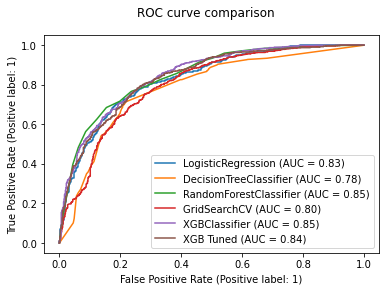

In [113]:
from sklearn.metrics import plot_roc_curve


fig = plot_roc_curve( model , X_test, y_test)

fig = plot_roc_curve( dtc  , X_test, y_test, ax = fig.ax_)


fig = plot_roc_curve( Rf_model   , X_test, y_test, ax = fig.ax_)



fig = plot_roc_curve( rf_grid   , X_test, y_test, ax = fig.ax_)

fig = plot_roc_curve( model_xgboost    , X_test, y_test, ax = fig.ax_)
fig = plot_roc_curve( model_xgboost_tuned    , X_test, y_test, ax = fig.ax_,name='XGB Tuned')

fig.figure_.suptitle("ROC curve comparison")
plt.show() 

Summarizing the results:

Random Forest and XGBoost were overall the best models, followed by Logistic Regression
DecisionTree was the worst performer

# 13 Test example with request to AWS cloud service

In [ ]:
import requests
urlAws = 'http://ec2-18-222-227-70.us-east-2.compute.amazonaws.com:9696/predict'
rest1 = {'restaurant_name': 'via_delhi',
 'country_code': 214,
 'city': 'abu_dhabi',
 'longitude': 54.374273233100006,
 'latitude': 24.4910933909,
 'cuisines': 'indian,north_indian,chinese',
 'average_cost_for_two': 100,
 'currency': 'emirati_diram(aed)',
 'has_table_booking': 0,
 'has_online_delivery': 1,
 'is_delivering_now': 1,
 'price_range': 3,
 'votes': 1148}

response = requests.post(urlAws, json=rest1).json()
print("AWS recommendation to book this restaurant or not (1-yes, 0-no): ")
print(response)

# 14 Test example with request to Flask service
You have to launch it before sending request - take a look at readme if fails!
(#pipenv run gunicorn --bind 0.0.0.0:9696 predict:app)

In [114]:
import requests
url = 'http://localhost:9696/predict'
rest = {'restaurant_name': 'via_delhi',
 'country_code': 214,
 'city': 'abu_dhabi',
 'longitude': 54.374273233100006,
 'latitude': 24.4910933909,
 'cuisines': 'indian,north_indian,chinese',
 'average_cost_for_two': 100,
 'currency': 'emirati_diram(aed)',
 'has_table_booking': 0,
 'has_online_delivery': 1,
 'is_delivering_now': 1,
 'price_range': 3,
 'votes': 1148}

response = requests.post(url, json=rest).json()
print("AWS recommendation to book this restaurant or not (1-yes, 0-no): ")
print(response)

AWS recommendation to book this restaurant or not (1-yes, 0-no): 
{'book_decision': 0.5428985581788336}
